In [1]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np
import os
import pandas as pd
import math
def calculate_metrics(real_dir, generated_dir, output_psnr_csv, output_ssim_csv):
    # 이미지 파일 목록 가져오기
    real_images = sorted([f for f in os.listdir(real_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', 'webp'))])
    generated_images = sorted([f for f in os.listdir(generated_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])

    

    # 결과를 저장할 리스트 초기화
    psnr_results = []
    ssim_results = []
    for gen in generated_images:
        for real in real_images:
            real_path = os.path.join(real_dir, real)
            gen_path = os.path.join(generated_dir, gen)

            try:
            # 이미지 열기
                real_image = Image.open(real_path).convert('RGB')
                gen_image = Image.open(gen_path).convert('RGB')

            # 이미지 크기 맞추기 (필요 시)
                if real_image.size != gen_image.size:
                    gen_image = gen_image.resize(real_image.size)

            # NumPy 배열로 변환
                real_np = np.array(real_image)
                gen_np = np.array(gen_image)

            # PSNR 계산
                psnr_value = round(psnr(real_np, gen_np, data_range=gen_np.max() - gen_np.min()),3)
                psnr_results.append({'gen_image' : gen,'real_image': real,'psnr': psnr_value})

            # SSIM 계산 (채널별 평균)
                ssim_value = round(ssim(real_np, gen_np, channel_axis=2),3)
                ssim_results.append({'gen_image' : gen,'real_image': real,'ssim': ssim_value})

                #print(f"{img_name} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

            except Exception as e:
                print(f" 오류 발생: {e}")

    # DataFrame으로 변환
    df_psnr = pd.DataFrame(psnr_results).pivot(index='gen_image', columns='real_image', values='psnr')
    df_ssim = pd.DataFrame(ssim_results).pivot(index='gen_image', columns='real_image', values='ssim')

    # CSV 파일로 저장
    df_psnr.to_csv(output_psnr_csv, encoding='utf-8-sig')
    df_ssim.to_csv(output_ssim_csv, encoding='utf-8-sig')

    print(f"PSNR 결과가 '{output_psnr_csv}'에 저장되었습니다.")
    print(f"SSIM 결과가 '{output_ssim_csv}'에 저장되었습니다.")

    return df_psnr,df_ssim

In [2]:
df_psnr, df_ssim = calculate_metrics('./real_images', './images_split', 'psnr.csv', 'ssim.csv')

PSNR 결과가 'psnr.csv'에 저장되었습니다.
SSIM 결과가 'ssim.csv'에 저장되었습니다.


In [3]:
df_psnr_reset = pd.read_csv('psnr.csv',index_col='gen_image').reset_index()
df_ssim_reset = pd.read_csv('ssim.csv',index_col='gen_image').reset_index()

In [4]:
df_psnr_reset['Group_gen'] = df_psnr_reset['gen_image'].str[:-10]
df_ssim_reset['Group_gen'] = df_ssim_reset['gen_image'].str[:-10]

In [5]:
df_ssim_reset.head()

,gen_image,image1.webp,image2.jpg,image3.jpg,image4.webp,image5.png,Group_gen
0,miku0_part1.png,0.066,0.161,0.325,0.315,0.210,miku0
1,miku0_part2.png,0.076,0.178,0.331,0.310,0.208,miku0
2,miku0_part3.png,0.085,0.244,0.451,0.384,0.280,miku0
3,miku100_part1.png,0.069,0.150,0.285,0.281,0.193,miku100
4,miku100_part2.png,0.080,0.131,0.349,0.328,0.202,miku100


In [6]:
grouped_df_psnr = df_psnr_reset.groupby('Group_gen')[['image1.webp','image2.jpg','image3.jpg','image4.webp','image5.png']].mean()
grouped_df_ssim = df_ssim_reset.groupby('Group_gen')[['image1.webp','image2.jpg','image3.jpg','image4.webp','image5.png']].mean()

In [7]:
grouped_df_psnr['mean'] = grouped_df_psnr.mean(axis=1)
grouped_df_ssim['mean'] = grouped_df_ssim.mean(axis=1)

In [8]:
grouped_df_psnr.to_csv('psnr_mean.csv', encoding='utf-8-sig')
grouped_df_ssim.to_csv('ssim_mean.csv', encoding='utf-8-sig')

In [10]:
grouped_df_psnr = pd.read_csv('./psnr_mean.csv')
grouped_df_ssim = pd.read_csv('./ssim_mean.csv')

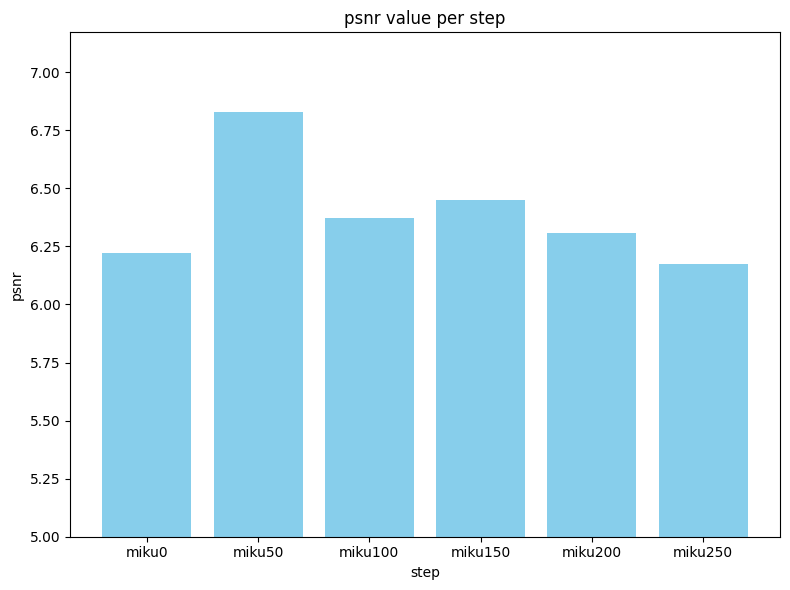

In [12]:
import matplotlib.pyplot as plt
# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(grouped_df_psnr['Group_gen'], grouped_df_psnr['mean'], color='skyblue')

# 레이블 및 제목 설정
plt.xlabel('step')
plt.ylabel('psnr')
plt.title('psnr value per step')
plt.ylim(5)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ssim value per step')

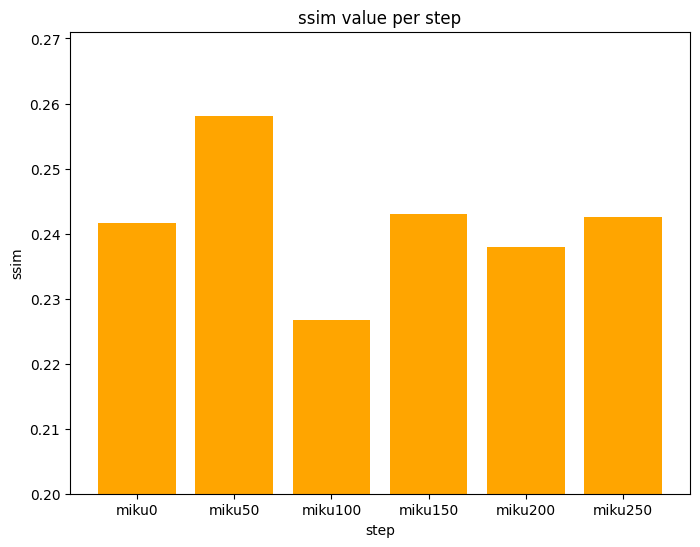

In [13]:
# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(grouped_df_ssim['Group_gen'], grouped_df_ssim['mean'], color='orange')

# 레이블 및 제목 설정
plt.xlabel('step')
plt.ylabel('ssim')
plt.ylim(0.2)
plt.title('ssim value per step')

In [16]:
grouped_df_psnr = grouped_df_psnr.round(3)
grouped_df_ssim = grouped_df_ssim.round(3)
grouped_df_psnr.to_csv('psnr_mean.csv', encoding='utf-8-sig')
grouped_df_ssim.to_csv('ssim_mean.csv', encoding='utf-8-sig')